## Import Packages

In [17]:
from pathlib import Path
import h5py
import numpy as np
import matplotlib.pyplot as plt 
import torch.nn as nn
import torch

project_path = Path.cwd().parent
print(f'project path: {project_path}')

project path: /home/dk/Desktop/projects/split-learning-1D-HE


## Load and Plot the Original Signals

In [3]:
with h5py.File(project_path/'data/train_ptbxl.hdf5') as hdf:
    X_train = hdf['X_train'][:]
    y_train = hdf['y_train'][:]

In [9]:
X_train.shape

(19267, 12, 1000)

Pick one signal for each class

In [5]:
superclasses = {0: "NORM", 1: "CD", 2: "MI", 3: "HYP", 4: "STTC"}
indices = []

for superclass in range(5):
    filt = y_train == superclass
    selected_index = np.where(filt)[0][0]
    indices.append(selected_index)


Plot the signals

In [39]:
def plotting(x, y):
    """
    x's shape: [number of channels, # time steps]
    y (int)
    """
    fig, axes = plt.subplots(x.shape[0], 1, figsize=(10,10))
    title = f"{superclasses[y]}"
    axes[0].set_title(title, fontsize=15)

    for i in range(x.shape[0]):
        axes[i].plot(x[i, :], color='C'+str(i))
        axes[i].set_xticks(np.arange(0, x.shape[1], 100))
        
    plt.tight_layout()
    plt.show()

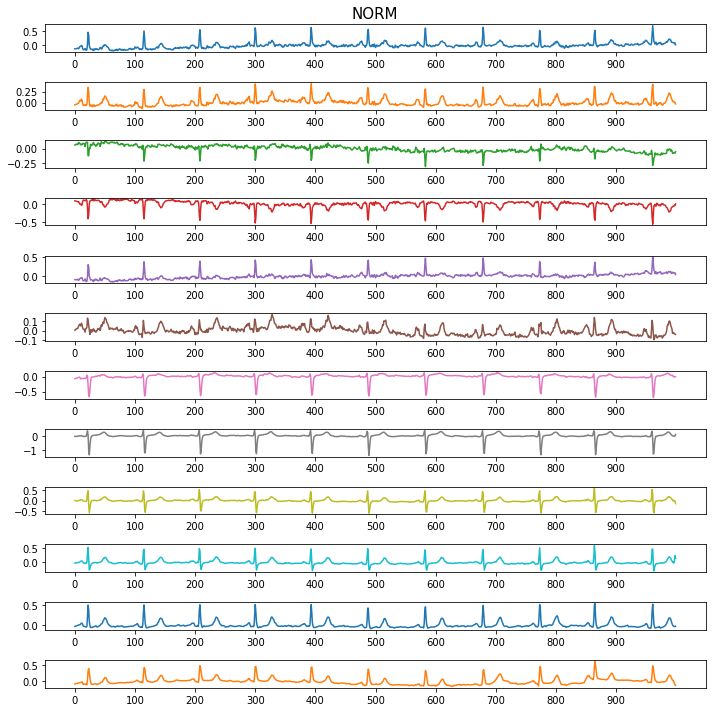

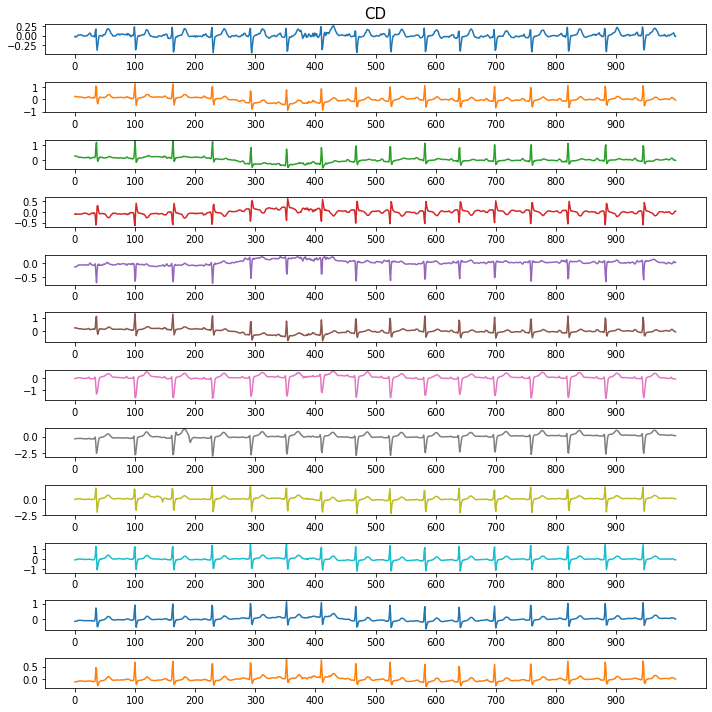

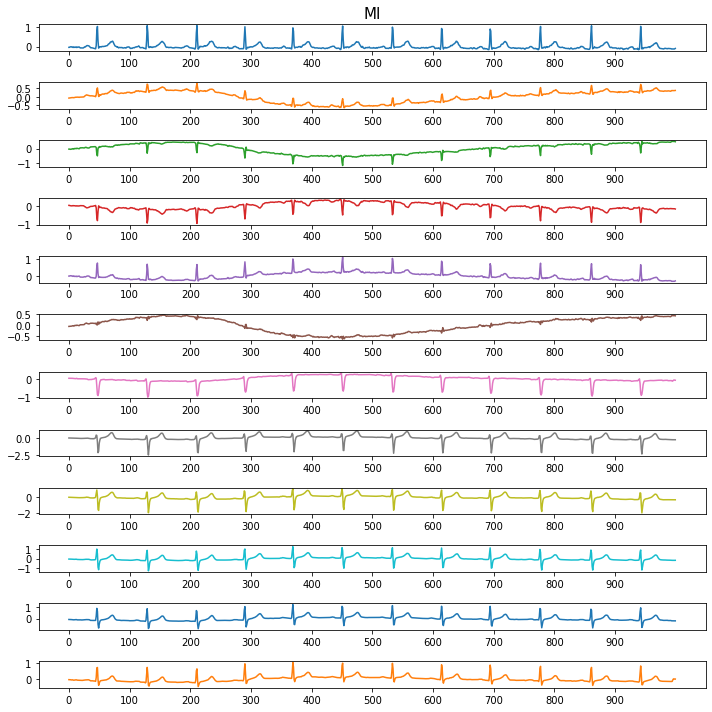

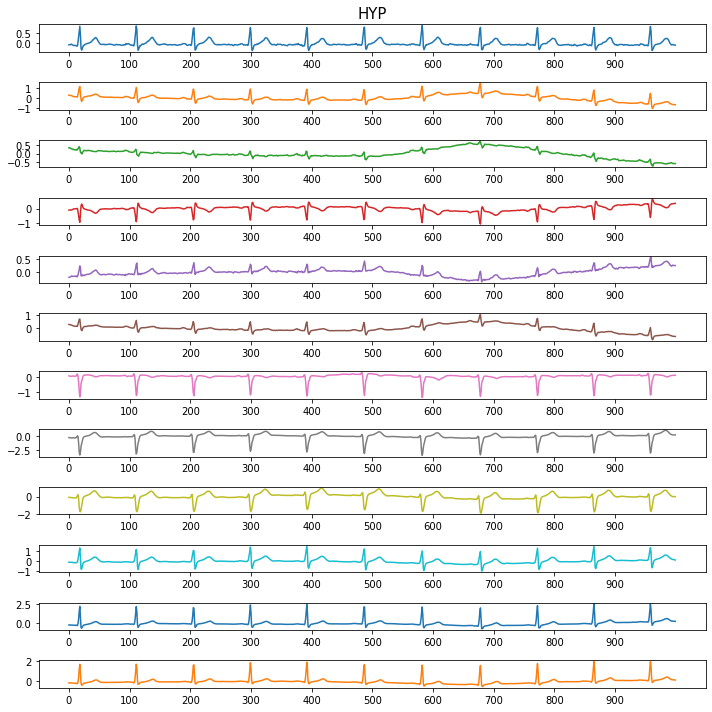

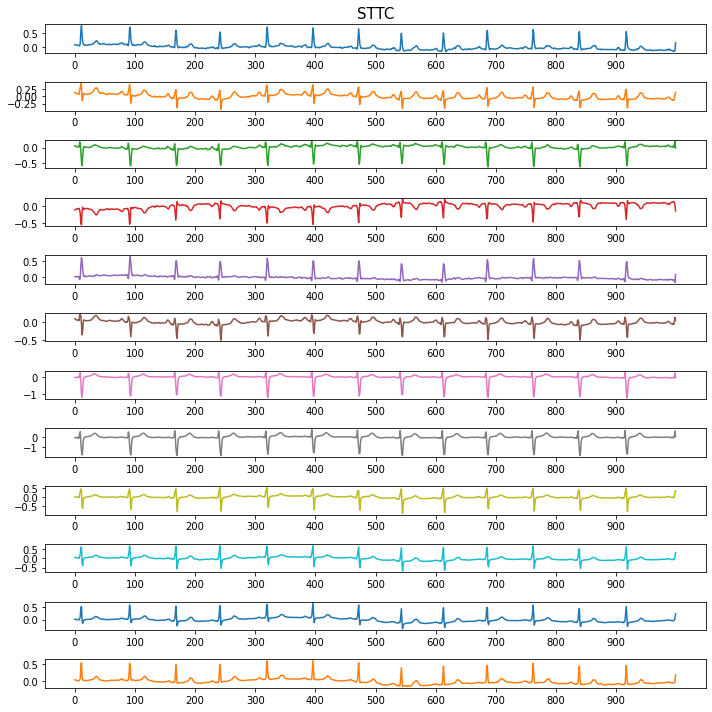

In [40]:
for i in indices:
    y_selected = y_train[i]
    x_selected = X_train[i]
    plotting(x_selected, y_selected)

## Generate and Plot the Activation Maps

### Model

In [19]:
class ECGConv1D(nn.Module):
    def __init__(self):
        super(ECGConv1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=12,
                               out_channels=16,
                               kernel_size=7,
                               padding=3,
                               stride=1)  # 16 x 1000
        self.relu1 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool1d(2)  # 16 x 500
        self.conv2 = nn.Conv1d(in_channels=16,
                               out_channels=8,
                               kernel_size=5,
                               padding=2)  # 8 x 500
        self.relu2 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool1d(2)  # 8 x 250 = 2000

        self.linear = nn.Linear(8*250, 5)
        self.softmax = nn.Softmax(dim=1)  # 0 is the batch dimension
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        # x = x.view(-1, 250*8)
        x = x.data.numpy().squeeze()

        return x

model = ECGConv1D()
model.load_state_dict(torch.load('weights/trained_weight_ptbxl.pth'))
model.eval()

ECGConv1D(
  (conv1): Conv1d(12, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 8, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=2000, out_features=5, bias=True)
  (softmax): Softmax(dim=1)
)

### Activation Maps

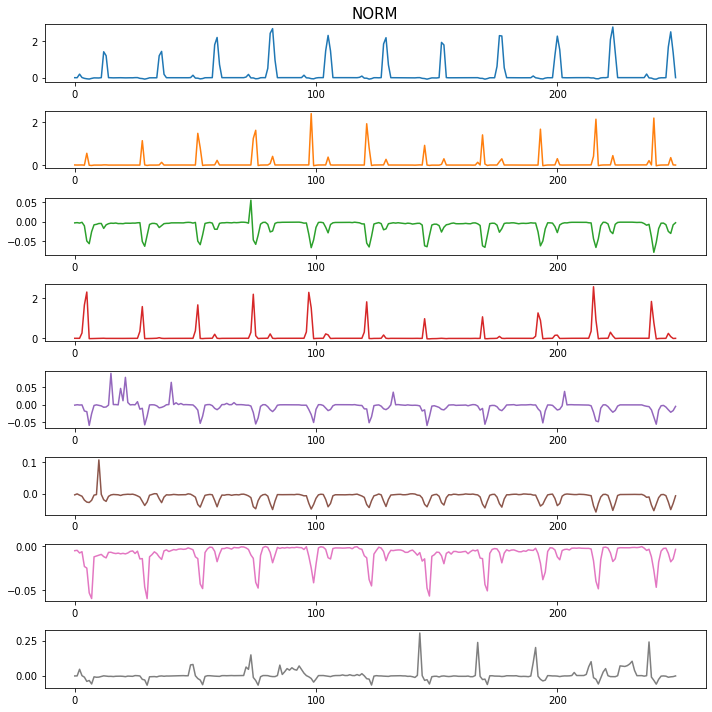

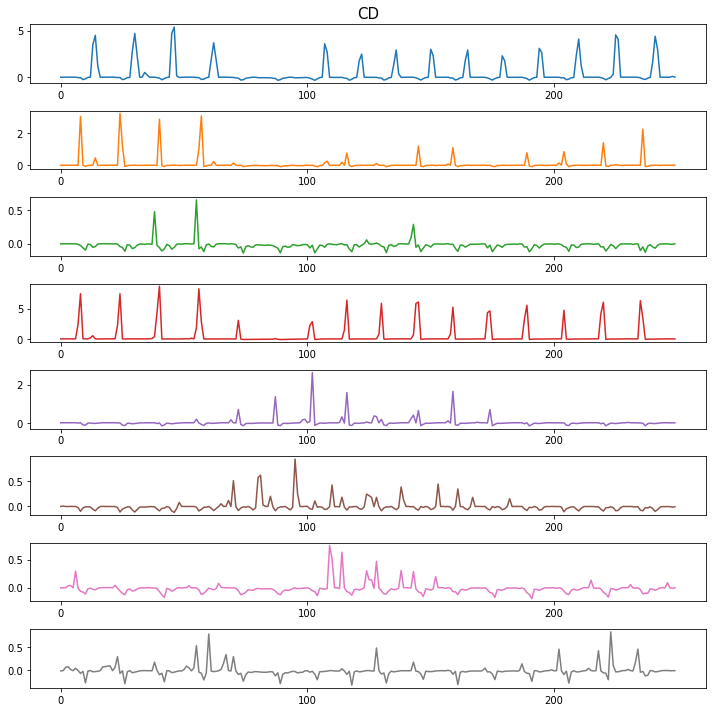

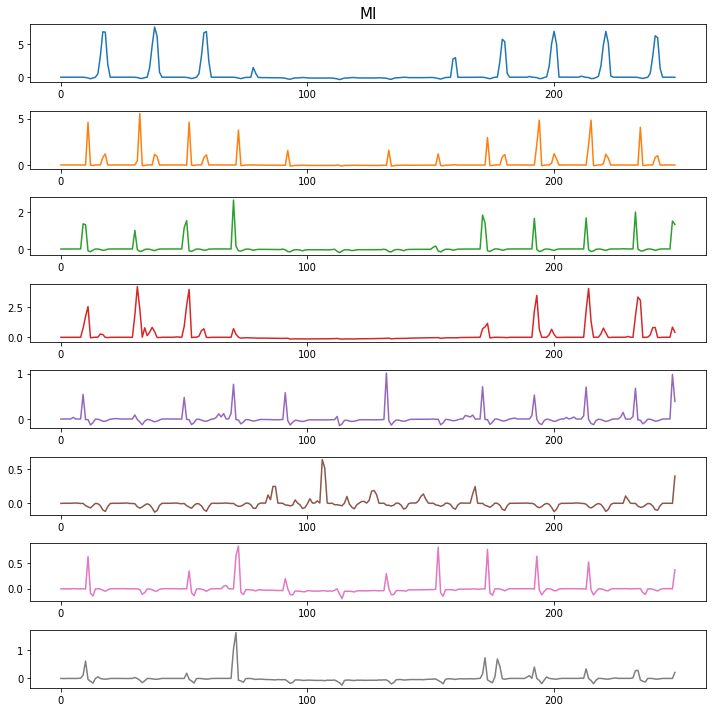

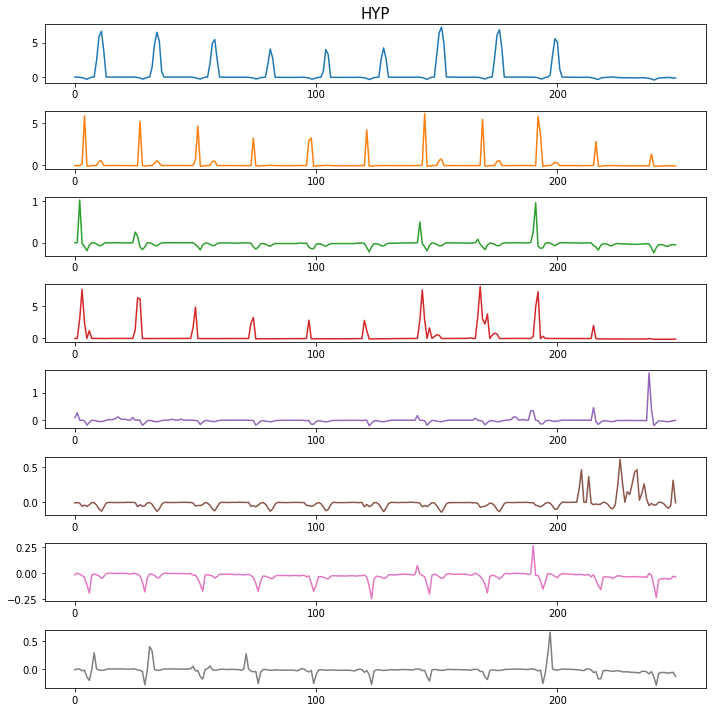

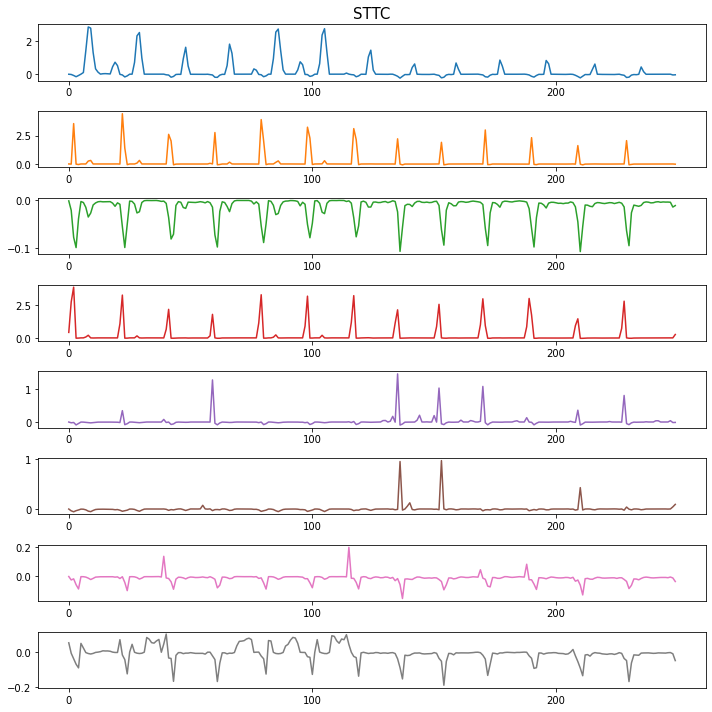

In [43]:
for i in indices:
    y = y_train[i]
    x = X_train[i]
    x = torch.tensor(np.expand_dims(x, axis=0), 
                     dtype=torch.float,
                     requires_grad=False)
    a = model(x)
    plotting(a, y)
    